# Defining MLP

In [1]:
import os
os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
print(os.getcwd())

/Users/mikolajmroz/Developer/Computational_Intelligence_Methods


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [4]:
def sigmoid_derivative(x):
    # Corrected sigmoid derivative to properly compute the derivative
    return sigmoid(x) * (1 - sigmoid(x))

In [38]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [39]:
class MLP:
    """
    Multilayer Perceptron (MLP) Class:
    A simple implementation of a feedforward neural network that uses backpropagation for training.

    Attributes:
    - layer_sizes (list): The sizes of the layers in the neural network.
    - layer_weights (list): Weights for each layer in the neural network, initialized based on He initialization.
    - layer_biases (list): Biases for each layer in the neural network, initialized to zeros.
    """
    
    def __init__(self, sizes, activation_fn='sigmoid'):
        """
        Initializes a new MLP instance.
        
        Parameters:
        - sizes (list): A list containing the size (number of neurons) of each layer in the network.
        - activation_fn (str): The name of the activation function to use ('sigmoid' by default).
        """
        self.layer_sizes = sizes
        
        # Initialize weights with He initialization for ReLU activations; suitable for layers not using ReLU, but common.
        self.layer_weights = [
            np.random.randn(next_layer, prev_layer) * np.sqrt(2.0 / prev_layer)
            for prev_layer, next_layer in zip(sizes[:-1], sizes[1:])
        ]
        
        # Initialize biases for all layers (except input layer) to zeros.
        self.layer_biases = [np.zeros((neurons, 1)) for neurons in sizes[1:]]

    def display_weights_biases(self):
        """Prints the weights and biases of each layer in the network."""
        print("Final Weights and Biases:")
        for layer_index, (weights, biases) in enumerate(zip(self.layer_weights, self.layer_biases)):
            print(f"Layer {layer_index + 1} Weights:\n{weights}")
            print(f"Layer {layer_index + 1} Biases:\n{biases}")

    def cost_derivative(self, output_acts, true_val):
        # Calculate the derivative of the cost function
        return (output_acts - true_val)
    
    def propagate_forward(self, input_activation):
        """
        Performs forward propagation using the current network weights and biases.
        
        Parameters:
        - input_activation (ndarray): The input data to the network.
        
        Returns:
        - The output of the network.
        - A list of activations for each layer including the input.
        """
        activations = [input_activation]  # Store all layer activations starting with the input.
        for biases, weights in zip(self.layer_biases, self.layer_weights):
            input_activation = sigmoid(np.dot(weights, input_activation) + biases)
            activations.append(input_activation)
        return activations[-1], activations  # Return final output and all layer activations.

    def backward_propagation(self, input_val, true_val):
        """
        Performs backpropagation, computing the gradient of the loss function with respect to weights and biases.
        
        Parameters:
        - input_val (ndarray): The input data.
        - true_val (ndarray): The true labels or values for the input data.
        
        Returns:
        - Gradients for the network's weights and biases.
        """
        weight_gradients = [np.zeros(weight.shape) for weight in self.layer_weights]
        bias_gradients = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Forward pass to get activations and pre-activation values.
        final_act, activations = self.propagate_forward(input_val)
        
        # Calculate error at the output layer.
        error = self.cost_derivative(final_act, true_val) * sigmoid_derivative(activations[-1])
        bias_gradients[-1] = error
        weight_gradients[-1] = np.dot(error, activations[-2].T)
        
        # Backpropagate the error to previous layers.
        for l in range(2, len(self.layer_sizes)):
            z = np.dot(self.layer_weights[-l+1].T, error) + self.layer_biases[-l+1]
            error = np.dot(self.layer_weights[-l+1].T, error) * sigmoid_derivative(z)
            bias_gradients[-l] = error
            weight_gradients[-l] = np.dot(error, activations[-l-1].T)
        
        return weight_gradients, bias_gradients

    def update_batch(self, batch, learn_rate, regularization, total_size, optimization_method, beta, epsilon=None):
        """
        Updates the weights and biases of the network for a single batch using gradient descent with regularization
        and optionally applies momentum or RMSprop as optimization methods to accelerate convergence.
    
        Parameters:
        - batch (list of tuples): Each tuple contains input data and true labels/values for a batch of samples.
        - learn_rate (float): Learning rate for the optimization.
        - regularization (float): Regularization factor to reduce overfitting by penalizing large weights.
        - total_size (int): Total number of samples in the dataset, used for regularization calculation.
        - optimization_method (str): Specifies the optimization method ('momentum' or 'rmsprop').
        - beta (float): Hyperparameter for the optimization methods, affecting the weighting of past gradients.
        - epsilon (float, optional): A small number to avoid division by zero in 'rmsprop', default is None.
    
        Returns:
        - None, but updates the network's weights and biases in place.
        """
        # Initialize gradients for weights and biases with zeros
        gradient_w = [np.zeros(weight.shape) for weight in self.layer_weights]
        gradient_b = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Loop through each data point in the batch
        for input_val, true_val in batch:
            # Perform backpropagation to compute gradients for current data point
            delta_gradient_w, delta_gradient_b = self.backward_propagation(input_val, true_val)
            # Accumulate gradients over the batch
            gradient_w = [w + dw for w, dw in zip(gradient_w, delta_gradient_w)]
            gradient_b = [b + db for b, db in zip(gradient_b, delta_gradient_b)]

        # Apply optimization method if specified
        if optimization_method == 'momentum':
            # Initialize velocity terms for weights and biases if not already initialized
            if not hasattr(self, 'velocity_weights'):
                self.velocity_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.velocity_biases = [np.zeros_like(b) for b in self.layer_biases]
                
            # Update velocities based on gradients and apply to weights and biases
            self.velocity_weights = [beta * vw + (1 - beta) * gw for vw, gw in zip(self.velocity_weights, gradient_w)]
            self.velocity_biases = [beta * vb + (1 - beta) * gb for vb, gb in zip(self.velocity_biases, gradient_b)]
            # Update weights and biases using momentum method
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - learn_rate * vw
                                  for w, vw in zip(self.layer_weights, self.velocity_weights)]
            self.layer_biases = [b - learn_rate * vb for b, vb in zip(self.layer_biases, self.velocity_biases)]
            
        elif optimization_method == 'rmsprop':
            # Initialize squared gradient terms for weights and biases if not already initialized
            if not hasattr(self, 'squared_gradients_weights'):
                self.squared_gradients_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.squared_gradients_biases = [np.zeros_like(b) for b in self.layer_biases]
                
            # Update squared gradients based on new gradients
            self.squared_gradients_weights = [beta * sgw + (1 - beta) * (gw**2)
                                              for sgw, gw in zip(self.squared_gradients_weights, gradient_w)]
            self.squared_gradients_biases = [beta * sgb + (1 - beta) * (gb**2)
                                             for sgb, gb in zip(self.squared_gradients_biases, gradient_b)]
            # Update weights and biases using rmsprop method
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - 
                                  (learn_rate / (np.sqrt(sgw) + epsilon)) * gw
                                  for w, sgw, gw in zip(self.layer_weights, self.squared_gradients_weights, gradient_w)]
            self.layer_biases = [b - (learn_rate / (np.sqrt(sgb) + epsilon)) * gb
                                 for b, sgb, gb in zip(self.layer_biases, self.squared_gradients_biases, gradient_b)]
    
    def train(self, training_set, epoch_count, learn_rate, batch_size_input, regularization=0.0,
              visual_interval=100, optimization_method='momentum', beta=0.9, epsilon=1e-8, 
              X_val_scaled=None, y_val_scaled=None, X_val=None, y_val=None,
              scaler_X=None, scaler_y=None, mse_limit=None):
        """
        Trains the neural network over a specified number of epochs using mini-batch gradient descent,
        and tracks performance over epochs through mean squared error on a validation set. Supports learning
        rate scheduling, regularization, and early stopping.
    
        Parameters:
        - training_set (list): Training data consisting of tuples of input values and true labels.
        - epoch_count (int): Total number of epochs to train the network.
        - learn_rate (float): Initial learning rate for optimization.
        - batch_size_input (int or float): Size of the mini-batches for training. If float, it represents
          the percentage of the total dataset size.
        - regularization (float): Regularization factor for reducing overfitting.
        - visual_interval (int): Frequency of epochs at which to calculate and print the MSE for tracking.
        - optimization_method (str): Optimization method to use ('momentum' or 'rmsprop').
        - beta (float): Parameter for the optimization method that controls the momentum or the weighted average.
        - epsilon (float): Small value to prevent division by zero in 'rmsprop'.
        - X_val_scaled, y_val_scaled, X_val, y_val (ndarray, optional): Validation datasets for performance evaluation.
        - scaler_X, scaler_y (preprocessing scaler objects, optional): Scalers used for transforming data back to original scale for MSE calculation.
        - mse_limit (float, optional): MSE value at which training can be stopped early for performance.
    
        Returns:
        - mse_history (list): History of mean squared error values at each visual interval.
        """
    
        # Initialize an empty list to store the history of mean squared errors (MSE) for each epoch
        mse_history = []
        # Determine the total number of samples in the training set
        data_size = len(training_set)
        # Store the initial learning rate, which may be adjusted during training
        rate_init = learn_rate
    
        # Determine mini-batch size based on whether the batch_size_input is a percentage or fixed value
        if isinstance(batch_size_input, float):  # If batch_size_input is a float, treat it as a percentage
            mini_batch_size = max(1, min(data_size, int(data_size * batch_size_input / 100)))
        elif isinstance(batch_size_input, int):  # If batch_size_input is an integer, treat it as a fixed size
            mini_batch_size = max(1, min(data_size, batch_size_input))
        else:  # Raise an error if batch_size_input is neither float nor int
            raise ValueError("batch_size_input must be an integer (fixed size) or a float (percentage of dataset)")
    
        # Iterate through each epoch for training
        for epoch in range(epoch_count):
            # Randomly shuffle the training set to ensure randomness of mini-batches
            np.random.shuffle(training_set)
            # Create mini-batches from the training set
            mini_batches = [training_set[k:k + mini_batch_size] for k in range(0, data_size, mini_batch_size)]
            # Update the model's weights and biases for each mini-batch
            for mini_batch in mini_batches:
                self.update_batch(mini_batch, learn_rate, regularization, data_size, optimization_method, beta, epsilon)
    
            # Adjust the learning rate after each epoch (simple learning rate decay)
            learn_rate = rate_init / (1 + 0.01 * epoch)
    
            # At specified intervals or the last epoch, evaluate and print the model's performance
            if epoch % visual_interval == 0 or epoch == epoch_count - 1:
                # Generate predictions for the validation set
                predictions_scaled_mse = np.array(
                    [self.propagate_forward(x.reshape(-1, 1))[0] for x in X_val_scaled])
    
                # Inverse transform the scaled predictions back to their original scale
                predictions_mse = scaler_y.inverse_transform(predictions_scaled_mse.reshape(-1, 1))
    
                # Calculate the mean squared error on the validation set
                current_mse = mse(predictions_mse, y_val)
                # Append the MSE to the history for tracking
                mse_history.append((epoch, current_mse))
                # Print the current epoch and its MSE
                print(f'Epoch {epoch}, MSE: {current_mse}')
    
                # If a threshold for MSE is set and the current MSE is below this threshold, stop training
                if mse_limit is not None and current_mse < mse_limit:
                    break
    
        # Return the history of MSE values
        return mse_history
    
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            # Add bias values next to the nodes
            for j in range(self.layer_sizes[i]):
                if j < len(self.layer_biases[i]):
                    ax.text(i, j, f'b={self.layer_biases[i][j, 0]:.2f}', color='blue', ha='right')
    
        plt.show()
        
    def visualize_network_working(self):
        fig, ax = plt.subplots()

        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))

            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)

        plt.show()



In [40]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [41]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [42]:
df_train_square_large = pd.read_csv('./data/regression/square-large-training.csv')
df_test_square_large = pd.read_csv('./data/regression/square-large-test.csv')

In [43]:
df_train_steps_large = pd.read_csv('./data/regression/steps-large-training.csv')
df_test_steps_large = pd.read_csv('./data/regression/steps-large-test.csv')

In [44]:
df_train_multimodal_large = pd.read_csv('./data/regression/multimodal-large-training.csv')
df_test_multimodal_large = pd.read_csv('./data/regression/multimodal-large-test.csv')

In [45]:
X_train_square_large = df_train_square_large['x'].values.reshape(-1, 1)
y_train_square_large = df_train_square_large['y'].values.reshape(-1, 1)

In [46]:
X_test_square_large = df_test_square_large['x'].values.reshape(-1, 1)
y_test_square_large = df_test_square_large['y'].values.reshape(-1, 1)

In [47]:
X_train_steps_large = df_train_steps_large['x'].values.reshape(-1, 1)
y_train_steps_large = df_train_steps_large['y'].values.reshape(-1, 1)

In [48]:
X_test_steps_large = df_test_steps_large['x'].values.reshape(-1, 1)
y_test_steps_large = df_test_steps_large['y'].values.reshape(-1, 1)

In [49]:
X_train_multimodal_large = df_train_multimodal_large['x'].values.reshape(-1, 1)
y_train_multimodal_large = df_train_multimodal_large['y'].values.reshape(-1, 1)

In [50]:
X_test_multimodal_large = df_test_multimodal_large['x'].values.reshape(-1, 1)
y_test_multimodal_large = df_test_multimodal_large['y'].values.reshape(-1, 1)

### square-large dataset

In [51]:
scaler_X = DataScaler("standardization")
scaler_y = DataScaler("standardization")

In [52]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_square_large)
y_train_scaled = scaler_y.fit_transform(y_train_square_large)


In [53]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_square_large)
y_test_scaled = scaler_y.transform(y_test_square_large)

In [54]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square_large, y_train_square_large)]

In [55]:
mlp_square_1_5 = MLP([1, 6, 1] )

In [56]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [58]:
mlp_square_1_5.train(
    training_data_scaled, epoch_count=400, learn_rate=0.1, batch_size_input=10,
    optimization_method='momentum', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_square_large, y_val = y_test_square_large, scaler_y = scaler_y,
    mse_limit = 1
)

Epoch 0, MSE: 10477.972423655618
Epoch 100, MSE: 10445.396446924206
Epoch 200, MSE: 10434.50637094502
Epoch 300, MSE: 10425.299814843815
Epoch 399, MSE: 10421.406011506622


[(0, 10477.972423655618),
 (100, 10445.396446924206),
 (200, 10434.50637094502),
 (300, 10425.299814843815),
 (399, 10421.406011506622)]

In [ ]:
mlp_square_1_5.train(
    training_data_scaled, epoch_count=100000, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_square_large, y_val = y_test_square_large, scaler_y = scaler_y,
    mse_limit = 1
)

In [59]:
mlp_square_1_5.display_weights_biases()

Final Weights and Biases:
Layer 1 Weights:
[[-26.35626183]
 [ 11.68302287]
 [-20.56317856]
 [-23.66522791]
 [-27.02122941]
 [-32.00410131]]
Layer 1 Biases:
[[-17.02333192]
 [-53.47734983]
 [-13.61593497]
 [-15.64110591]
 [-17.53620391]
 [-20.62579981]]
Layer 2 Weights:
[[ 9.05230252  8.50876756 29.6915721  30.6461504  14.24400354  9.16710352]]
Layer 2 Biases:
[[-95.74486229]]


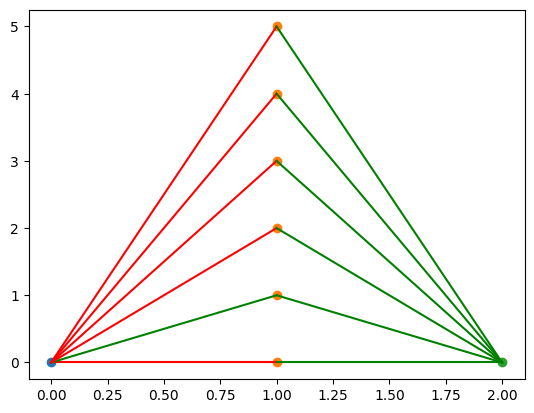

In [60]:
mlp_square_1_5.visualize_network_working()  

#### testing

In [61]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [62]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_square_large[i])
mse_score = mse(predictions, y_test_square_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-31.55471068] actual value:  [38.0481491]
predicted value:  [-31.55471068] actual value:  [-116.30927998]
predicted value:  [-31.55471068] actual value:  [-22.98888333]
predicted value:  [-31.55471068] actual value:  [163.49243459]
predicted value:  [-26.88818591] actual value:  [-50.79309017]
predicted value:  [-31.55471068] actual value:  [26.14905307]
predicted value:  [-31.55471068] actual value:  [-95.99910634]
predicted value:  [-31.55471068] actual value:  [-1.67979449]
predicted value:  [-26.86432465] actual value:  [11.84130953]
predicted value:  [-31.55471068] actual value:  [-36.5786339]
predicted value:  [-31.55471068] actual value:  [-49.85187483]
predicted value:  [-31.55471068] actual value:  [-38.70966897]
predicted value:  [-30.52816215] actual value:  [-89.65420844]
predicted value:  [-26.86428872] actual value:  [151.89903669]
predicted value:  [-31.55471068] actual value:  [-86.1941224]
predicted value:  [-26.86428872] actual value:  [172.6273849]

### multimodal-large dataset

In [58]:
# Initialize the scaler for X and y with the desired scaling method
scaler_X = DataScaler(method="min_max")
scaler_y = DataScaler(method="min_max")

In [59]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_multimodal_large)
y_train_scaled = scaler_y.fit_transform(y_train_multimodal_large)


In [60]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_multimodal_large)
y_test_scaled = scaler_y.transform(y_test_multimodal_large)

In [61]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_multimodal_large, y_train_multimodal_large)]

In [62]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] )

In [63]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [64]:
mlp_square_1_5.train(
    training_data_scaled, epoch_count=100000, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
    mse_limit = 9, visual_interval = 10
)

Epoch 0, MSE: 2571.1971656482024
Epoch 10, MSE: 348.41584548405484
Epoch 20, MSE: 263.2458292892844
Epoch 30, MSE: 409.9253375023777
Epoch 40, MSE: 38.93305934514824
Epoch 50, MSE: 16.587640718544957
Epoch 60, MSE: 28.80631621035437
Epoch 70, MSE: 96.12693360612931
Epoch 80, MSE: 53.86544386635945
Epoch 90, MSE: 10.879003919396458
Epoch 100, MSE: 13.706533099237326
Epoch 110, MSE: 32.58020158254048
Epoch 120, MSE: 12.455829040130626
Epoch 130, MSE: 14.884080465540016
Epoch 140, MSE: 9.285608209270947
Epoch 150, MSE: 10.671187652705187
Epoch 160, MSE: 20.159966162393573
Epoch 170, MSE: 5.853932407854354


#### testing

In [65]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [67]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_multimodal_large[i])
mse_score = mse(predictions, y_test_multimodal_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-97.52083727] actual value:  [-98.2081664]
predicted value:  [-54.25551153] actual value:  [-55.28389066]
predicted value:  [99.65196547] actual value:  [100.29999676]
predicted value:  [4.09228165] actual value:  [2.7206294]
predicted value:  [-73.86446255] actual value:  [-75.99163605]
predicted value:  [37.69087725] actual value:  [36.4875116]
predicted value:  [28.26103944] actual value:  [32.9071937]
predicted value:  [51.89040415] actual value:  [54.59378752]
predicted value:  [69.45158391] actual value:  [75.88595471]
predicted value:  [16.72811997] actual value:  [15.93020098]
predicted value:  [32.52955311] actual value:  [36.41048972]
predicted value:  [100.20211309] actual value:  [100.17958374]
predicted value:  [-95.59186227] actual value:  [-96.19000955]
predicted value:  [99.29064866] actual value:  [100.29859577]
predicted value:  [-63.8971626] actual value:  [-64.55778832]
predicted value:  [69.35791887] actual value:  [73.08482928]
predicted value: 

### steps-large dataset

In [101]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")


In [102]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_steps_large)
y_train_scaled = scaler_y.fit_transform(y_train_steps_large)


In [103]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_steps_large)
y_test_scaled = scaler_y.transform(y_test_steps_large)

In [104]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_steps_large, y_train_steps_large)]

In [105]:
mlp_square_1_5 = MLP([1, 64, 64, 1] )

In [106]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [107]:
mlp_square_1_5.train(
    training_data_scaled, epoch_count=100000, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
    mse_limit = 3, visual_interval = 10
)

Epoch 0, MSE: 389.38104398917005
Epoch 10, MSE: 131.4631568409038
Epoch 20, MSE: 78.73668777124136
Epoch 30, MSE: 59.69330932649057
Epoch 40, MSE: 49.47363285603985
Epoch 50, MSE: 26.439567845801832
Epoch 60, MSE: 100.19287454377563
Epoch 70, MSE: 79.30133793804217
Epoch 80, MSE: 70.41169262209822
Epoch 90, MSE: 72.40865362621943
Epoch 100, MSE: 31.768227223722842
Epoch 110, MSE: 49.00744649140912
Epoch 120, MSE: 45.408671237979505
Epoch 130, MSE: 30.925341013682797
Epoch 140, MSE: 24.315648547748186
Epoch 150, MSE: 27.542804988015313
Epoch 160, MSE: 21.066193000285235
Epoch 170, MSE: 18.742684019331236
Epoch 180, MSE: 39.33370989471286
Epoch 190, MSE: 44.825338790023665
Epoch 200, MSE: 17.257452079863306
Epoch 210, MSE: 31.82506431917291
Epoch 220, MSE: 19.090811219310417
Epoch 230, MSE: 47.53458422379407
Epoch 240, MSE: 26.881143084053992
Epoch 250, MSE: 25.191847693130534
Epoch 260, MSE: 19.264624280995346
Epoch 270, MSE: 14.402354790996998
Epoch 280, MSE: 15.67970375371662
Epoch 29

KeyboardInterrupt: 

#### testing

In [65]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [67]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_steps_large[i])
mse_score = mse(predictions, y_test_steps_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-97.52083727] actual value:  [-98.2081664]
predicted value:  [-54.25551153] actual value:  [-55.28389066]
predicted value:  [99.65196547] actual value:  [100.29999676]
predicted value:  [4.09228165] actual value:  [2.7206294]
predicted value:  [-73.86446255] actual value:  [-75.99163605]
predicted value:  [37.69087725] actual value:  [36.4875116]
predicted value:  [28.26103944] actual value:  [32.9071937]
predicted value:  [51.89040415] actual value:  [54.59378752]
predicted value:  [69.45158391] actual value:  [75.88595471]
predicted value:  [16.72811997] actual value:  [15.93020098]
predicted value:  [32.52955311] actual value:  [36.41048972]
predicted value:  [100.20211309] actual value:  [100.17958374]
predicted value:  [-95.59186227] actual value:  [-96.19000955]
predicted value:  [99.29064866] actual value:  [100.29859577]
predicted value:  [-63.8971626] actual value:  [-64.55778832]
predicted value:  [69.35791887] actual value:  [73.08482928]
predicted value: 

In [574]:
df_test_steps_large = pd.read_csv("data/regression/steps-large-test.csv")

X_test_steps_small = df_test_steps_large["x"].values.reshape(-1, 1)
y_test_steps_small = df_test_steps_large["y"].values.reshape(-1, 1)

In [575]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 0.22499592],
       [ 0.66393297],
       [ 0.81579735],
       [-0.93381363],
       [-1.56887485]]), array([[ 0.48408992, -0.90893581,  0.74451279,  0.26491836, -0.60762049],
       [ 0.21036234,  0.76803741,  0.00444413,  0.28424456, -0.40550138],
       [ 0.40071939, -0.39049337,  0.0533959 ,  0.28357303, -0.51281637],
       [-0.09733522,  0.20233363, -0.15237367, -0.91242117, -0.4788253 ],
       [ 0.66472232,  0.17079079,  0.40099151,  0.12026128,  0.05577142]]), array([[ 0.33198014, -0.44144792, -0.19640651, -0.21308176,  0.46809915]])]


In [576]:
# Fit and transform the training data
X_train_scaled2 = scaler_X.fit_transform(X_train_steps_small)
y_train_scaled2 = scaler_y.fit_transform(y_train_steps_small)


In [577]:
training_data_scaled2 = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled2, y_train_scaled2)
]

In [578]:
mlp_steps.train(
    training_data_scaled2, epochs=5000, learning_rate=0.1, batch_size=10
)

#### testing

In [579]:
# Scale the test data using the transform method
X_test_scaled2 = scaler_X.transform(X_test_steps_small)

In [580]:
# Generate predictions on the scaled test data
predictions_scaled2 = np.array(
    [mlp_steps.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled2]
)

In [581]:
# Correctly denormalize predictions
predictions2 = scaler_y.inverse_transform(predictions_scaled2.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions2)):
    print("predicted value: ",  predictions2[i], "actual value: ", y_test_steps_small[i])
mse_score2 = mse(predictions2, y_test_steps_small)

print(f"MSE Score: {mse_score2}")

predicted value:  [-75.68118152] actual value:  [-80]
predicted value:  [92.72419888] actual value:  [80]
predicted value:  [-88.27325684] actual value:  [-80]
predicted value:  [-70.89335599] actual value:  [-80]
predicted value:  [-78.9464397] actual value:  [-80]
predicted value:  [18.76146075] actual value:  [0]
predicted value:  [21.79168549] actual value:  [0]
predicted value:  [-87.52498457] actual value:  [-80]
predicted value:  [-74.5456806] actual value:  [-80]
predicted value:  [25.60761617] actual value:  [0]
predicted value:  [93.10415354] actual value:  [80]
predicted value:  [62.59932508] actual value:  [80]
predicted value:  [96.49685706] actual value:  [80]
predicted value:  [-75.53582894] actual value:  [-80]
predicted value:  [46.21620138] actual value:  [80]
predicted value:  [78.11865653] actual value:  [80]
predicted value:  [-18.89331856] actual value:  [0]
predicted value:  [146.8935984] actual value:  [160]
predicted value:  [-81.84228729] actual value:  [-80]


In [524]:
# nie ma optymalnego mse :((((